# Chapter 07 — CellBender Cell Typing

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


## Core Imports

In [1]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Union

## File Paths and Metadata

In [2]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(DATA_DIR, "figures", "chapter_08_cellbender_UMAP_clustering")
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_ADATA_DIR = os.path.join(
    ANALYSIS_DIR, "adatas", "chapter_07_cellbender_UMAP_clustering"
)
OUTPUT_ADATA_DIR = os.path.join(ANALYSIS_DIR, "adatas", "chapter_08_cellbender_cell_typing")

# Make sure output adata dir directory exists
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

## Read in AnnDatas

### Individual AnnDatas

In [3]:
# Load AnnData objects
adatas = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(INPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adata = sc.read_h5ad(file_path)
    adatas[key] = adata
    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 4483 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    uns: 'log1p', 'scrublet'
    layers: 'raw_data'
SL_N: AnnData object with n_obs × n_vars = 5505 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts

### Combined by Tissue AnnDatas

In [4]:
combined_by_tissue = {}
for tissue in adata_tissues:
    file_path = os.path.join(
        INPUT_ADATA_DIR, f"{tissue.replace(' ', '_')}_combined_adata.h5ad"
    )
    if os.path.exists(file_path):
        adata = sc.read_h5ad(file_path)
        combined_by_tissue[tissue] = adata
        print(f"Loaded combined AnnData for {tissue} from {file_path}")
        print(f"{tissue} AnnData: {adata}")
    else:
        raise FileNotFoundError(
            f"Combined AnnData for {tissue} not found at {file_path}. Skipping."
        )

Loaded combined AnnData for Normal Colon from ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/Normal_Colon_combined_adata.h5ad
Normal Colon AnnData: AnnData object with n_obs × n_vars = 9988 × 17979
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'connectivities', 'distances'
Loaded combined AnnData for Normal Colon from ./data/analysis/adatas/chapter_07_cellben

## Cell Typing

In [5]:
def plot_celltype_proportions_by_protocol(
    adata: sc.AnnData,
    tissue: str,
    protocol_color_palette: dict = None,
    annotate: bool = False,
    metric = "majority_voting"
) -> plt.Figure:
    """
    Plots bar chart of cell type proportions by protocol for a given tissue using Seaborn.

    Args:
        adata: AnnData object for the specific tissue.
        tissue: Tissue name to extract and plot.
        annotate: Whether to annotate bars with raw counts.
        protocol_color_palette: Optional dictionary mapping protocol to color.

    Returns:
        Matplotlib figure object.
    """
    obs = adata.obs[["protocol", metric]].copy()

    # Count and proportion
    counts = (
        obs.groupby(["protocol", metric]).size().reset_index(name="count")
    )
    total_per_protocol = counts.groupby("protocol")["count"].transform("sum")
    counts["proportion"] = counts["count"] / total_per_protocol

    # Sort cell types
    counts[metric] = counts[metric].astype(str)
    counts = counts.sort_values(metric)
    counts["percentage"] = counts["proportion"] * 100

    # Set up the plot
    sns.set_theme(style="white", font_scale=1.1)
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.barplot(
        data=counts,
        x=metric,
        y="percentage",
        hue="protocol",
        palette=protocol_color_palette,
        ax=ax,
        dodge=True,
    )

    if annotate:
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(
                    f"{height:.2f}",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

    # Format axes and legend
    ax.set_title(
        f"Cell Type Proportions by Protocol ({tissue})", fontsize=14, weight="bold"
    )
    ax.set_xlabel("Cell Type", fontsize=12)
    ax.set_ylabel("Percentage", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(title="Protocol", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    return fig

### Normal Liver

#### CellTypist

🔬 Input data has 12737 cells and 19258 genes
🔗 Matching reference genes in the model
🧬 2251 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


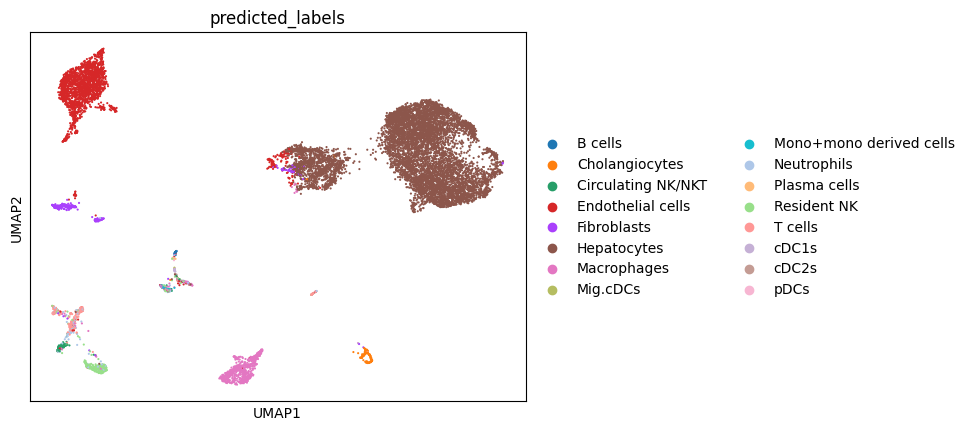

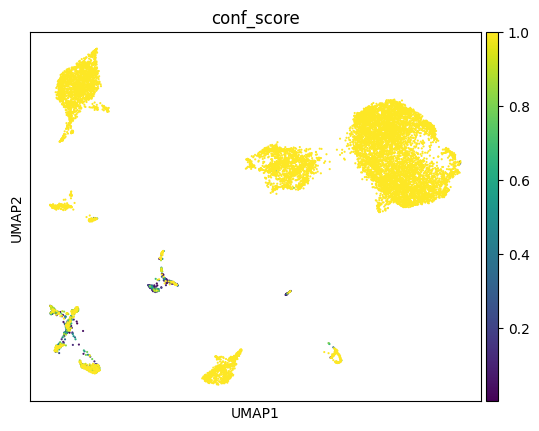

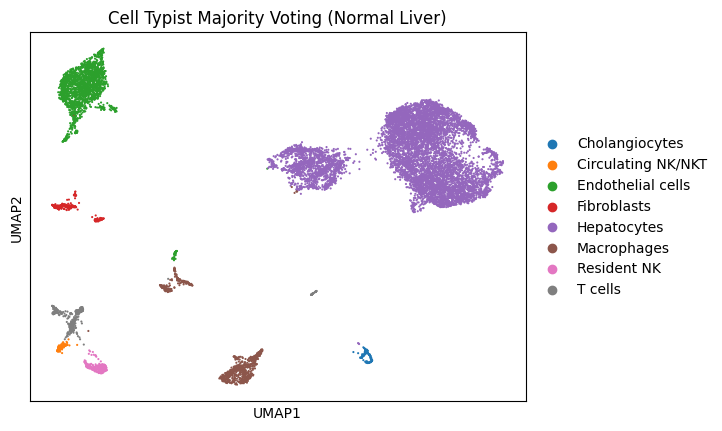

In [6]:
import celltypist

normal_liver_cell_typist_input = combined_by_tissue["Normal Liver"].copy()
normal_liver_cell_typist_input.X = normal_liver_cell_typist_input.layers[
    "raw_data"
].copy()
sc.pp.normalize_total(normal_liver_cell_typist_input, target_sum=1e4, inplace=True)
sc.pp.log1p(normal_liver_cell_typist_input)

liver_cell_predictions = celltypist.annotate(
    normal_liver_cell_typist_input,
    model="Healthy_Human_Liver.pkl",
    majority_voting=True,
    over_clustering="leiden",
)

liver_cell_predictions_adata = liver_cell_predictions.to_adata()

majority_voting_output_path = os.path.join(
    FIGURES_OUTPUT_DIR, "majority_voting_output.png"
)

sc.pl.umap(liver_cell_predictions_adata, color="predicted_labels")
sc.pl.umap(liver_cell_predictions_adata, color="conf_score")
fig = sc.pl.umap(
    liver_cell_predictions_adata,
    color="majority_voting",
    title="Cell Typist Majority Voting (Normal Liver)",
    return_fig=True,
)
fig.savefig(majority_voting_output_path, bbox_inches="tight")

#### Marker Genes

In [7]:
liver_marker_dict = {
    "Hepatocytes": [
        "APOB",
        "CYP3A4",
    ],  # https://www.nature.com/articles/s42003-022-04046-9
    "Cholangiocytes": [
        "KRT19",
        "CFTR",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC4315871/
    "Endothelial cells": [
        "PECAM1",
        "CDH5",
        "LDB2",
        "PTPRB",
    ],  # https://www.nature.com/articles/s41467-022-30633-9, CELL x GENE
    "Fibroblasts": [
        "COL1A2",
        "COL5A2",
        "COL6A3",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC7444611/, CELL x Gene
    "Macrophages": [
        "CD68",
        "C1QA",
        "C1QB",
        "C1QC",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC10153153/, https://pmc.ncbi.nlm.nih.gov/articles/PMC10849641/
    "Resident NK": [
        "KLRD1",
        "NCAM1",
    ],  # https://www.ncbi.nlm.nih.gov/gene/3824, https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2017.00892/full
    "T cells": [
        "CD3D",
        "CD3E",
        "CD3G",
        "CD2",
    ],  # https://pubmed.ncbi.nlm.nih.gov/39029632/
    "Circulating NK/NKT": [
        "NCAM1",
    ],  # CD56 https://pmc.ncbi.nlm.nih.gov/articles/PMC6529387/
}

#### Plot Dotplot

dendrogram data not found (using key=dendrogram_majority_voting). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


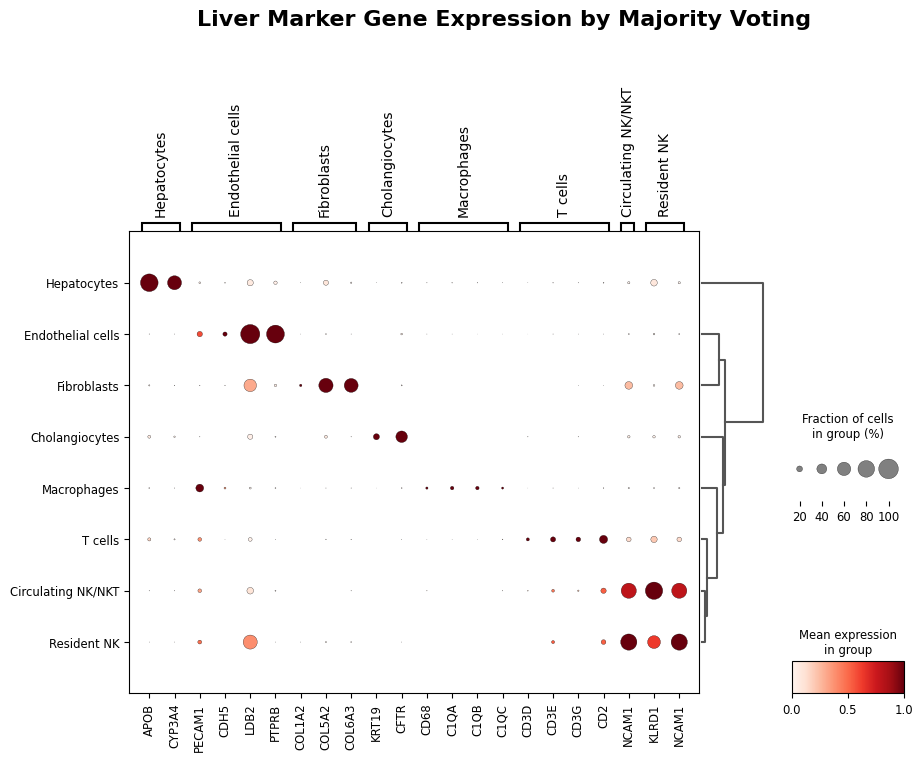

In [8]:
# Create the dotplot
liver_dp = sc.pl.dotplot(
    liver_cell_predictions_adata,
    var_names=liver_marker_dict,
    groupby="majority_voting",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = liver_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting",
    fontsize=16,
    weight="bold",
    y=1.25,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_dotplot.png"))

#### Plot Heatmap

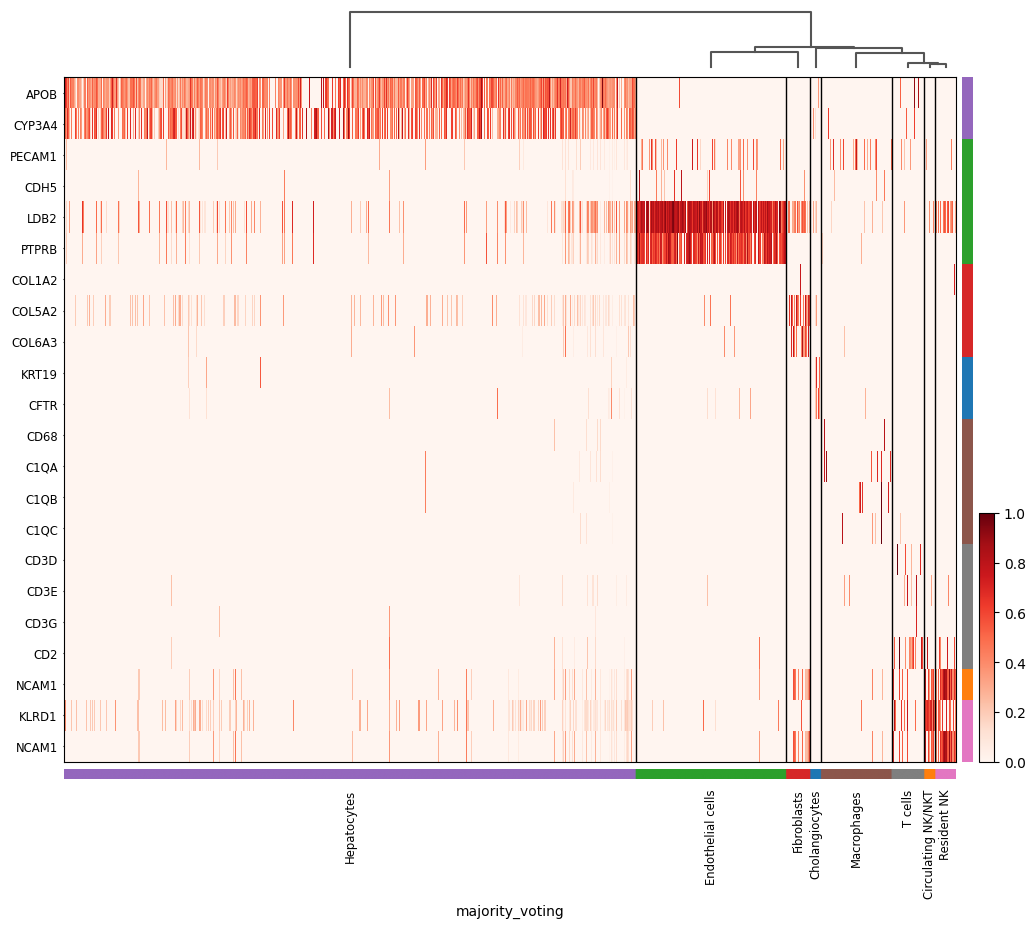

In [9]:
import os

# Create and store the heatmap object
liver_hm = sc.pl.heatmap(
    liver_cell_predictions_adata,
    var_names=liver_marker_dict,
    groupby="majority_voting",
    use_raw=False,
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_rotation=90,
    var_group_labels=liver_marker_dict.keys(),
    dendrogram=True,
    figsize=(12, 10),
    show=False,  # Prevent auto display
)


# Set title and adjust layout
fig = liver_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_heatmap.png"))

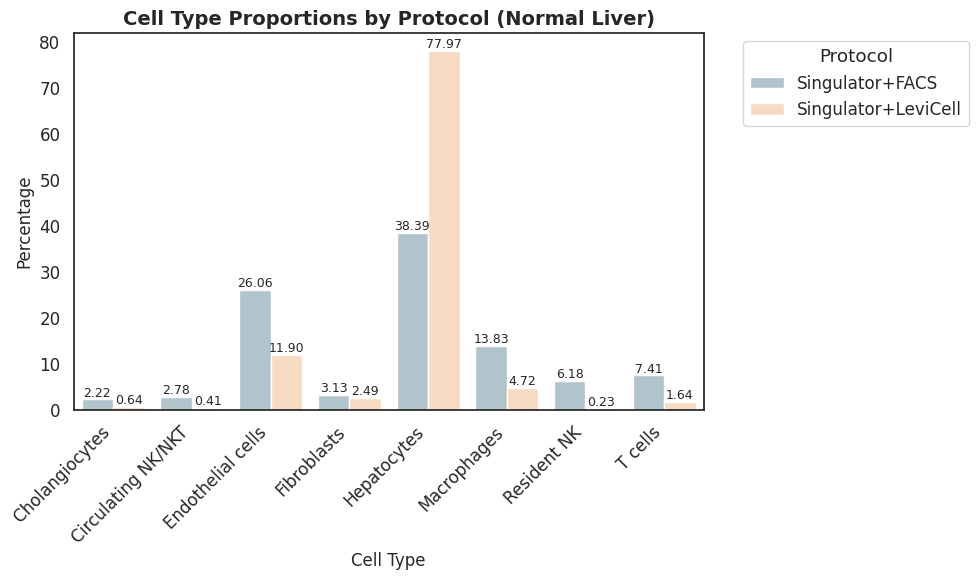

In [10]:
# Plot cell type proportions by protocol for Normal Liver
fig = plot_celltype_proportions_by_protocol(
    adata=liver_cell_predictions_adata,
    tissue="Normal Liver",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "umap_by_leiden.png"), bbox_inches="tight")

#### Add annotations to original AnnData

In [11]:
# Add annotations to original AnnData without a method

combined_by_tissue["Normal Liver"].obs["predicted_cell_type"] = (
    liver_cell_predictions_adata.obs["majority_voting"]
)

### Normal Colon

#### Functions

In [12]:
def assign_celltypes_by_marker_scoring(
    adata: sc.AnnData,
    cell_marker_genes: dict,
    cluster_key: str = "leiden",
    use_raw: bool = False,
    min_counts: int = None,
    min_score: float = None,
):
    """
    Scores gene sets and assigns cell types to clusters based on the highest scoring marker set,
    only for cells with library size greater than `min_counts` and scores above `min_score`.

    Args:
        adata: The annotated data matrix.
        cell_marker_genes: Dictionary mapping cell type names to marker gene lists.
        cluster_key: Key in `adata.obs` corresponding to cluster labels (e.g., 'leiden').
        use_raw: Whether to use raw expression values.
        min_counts: Minimum total counts required for a cell to be scored.
        min_score: Minimum score required to be considered in cell type assignment.

    Modifies:
        adata.obs:
            - Adds one column per cell type score.
            - Adds 'predicted_cell_type' column with majority-vote label per cluster.
    """
    if min_counts is not None:
        valid_cells = adata.obs["n_counts"] > min_counts
    else:
        valid_cells = pd.Series(True, index=adata.obs.index)

    scored = adata[valid_cells].copy()

    for label, genes in cell_marker_genes.items():
        sc.tl.score_genes(
            scored, gene_list=genes, score_name=f"{label}_score", use_raw=use_raw
        )

    for label in cell_marker_genes:
        score_col = f"{label}_score"
        adata.obs[score_col] = float("nan")
        adata.obs.loc[valid_cells, score_col] = scored.obs[score_col]

    score_cols = [f"{label}_score" for label in cell_marker_genes]
    score_df = adata.obs[score_cols]

    if min_score is not None:
        score_df = score_df.where(score_df >= min_score)

    adata.obs["predicted_cell_type"] = score_df.idxmax(axis=1).str.replace(
        "_score", "", regex=False
    )

    mode_labels = adata.obs.groupby(cluster_key)["predicted_cell_type"].agg(
        lambda x: x.value_counts().idxmax()
    )
    adata.obs["predicted_cell_type"] = adata.obs[cluster_key].map(mode_labels)

    return

In [13]:
colon_marker_dict = {
    "Epithelial": ["EPCAM", "KRT8", "KRT18"],
    "Stromal": ["COL6A2", "COL6A1", "COL1A1"],
    "Immune": [
        "PTPRC",
        "CD3E",
        "CD2",
        "CD3D",
        "CD3G",
        "FCER1G",
        "CSF1R",
        "CD14",
        "CD68",
        "CD38",
    ],
}

... storing 'predicted_cell_type' as categorical


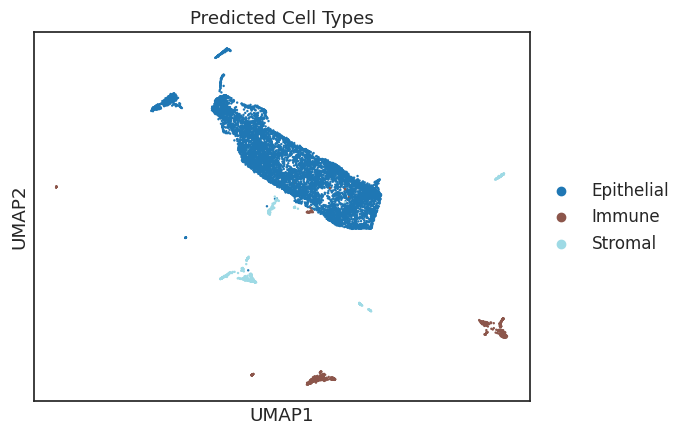

In [14]:
# Assign cell types to the colon adata
assign_celltypes_by_marker_scoring(
    adata=combined_by_tissue["Normal Colon"],
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
    use_raw=False,
    min_counts=None,
    min_score=0.15,
)

# Plot UMAP with predicted cell types for Normal Colon
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="predicted_cell_type",
    title="Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

dendrogram data not found (using key=dendrogram_predicted_cell_type). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


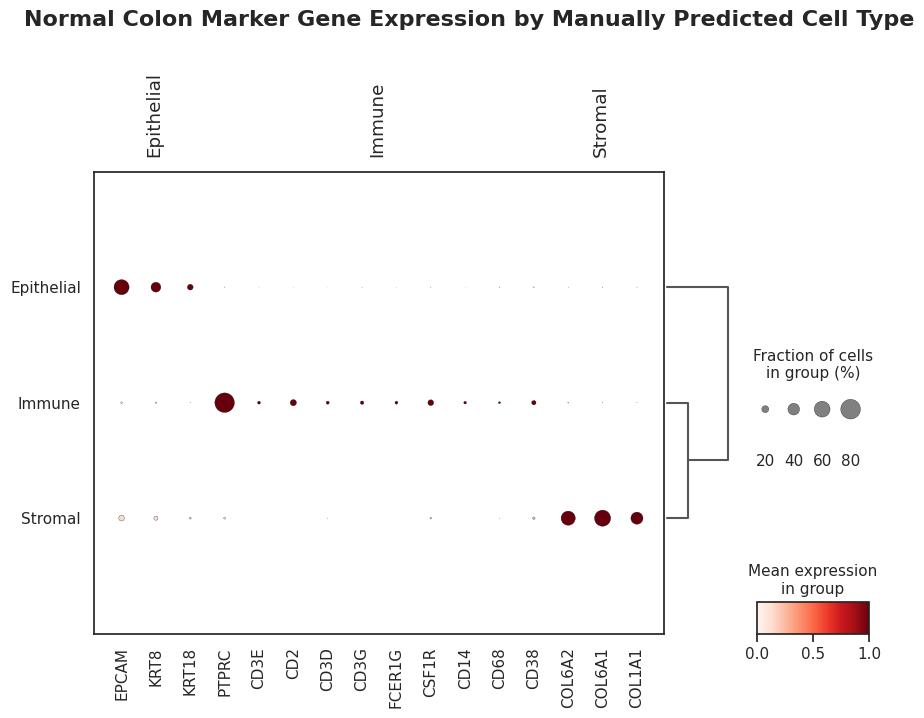

In [15]:
# Create the dotplot
normal_colon_dp = sc.pl.dotplot(
    combined_by_tissue["Normal Colon"],
    var_names=colon_marker_dict,
    groupby="predicted_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = normal_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Normal Colon Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_marker_dot_plot.png"))

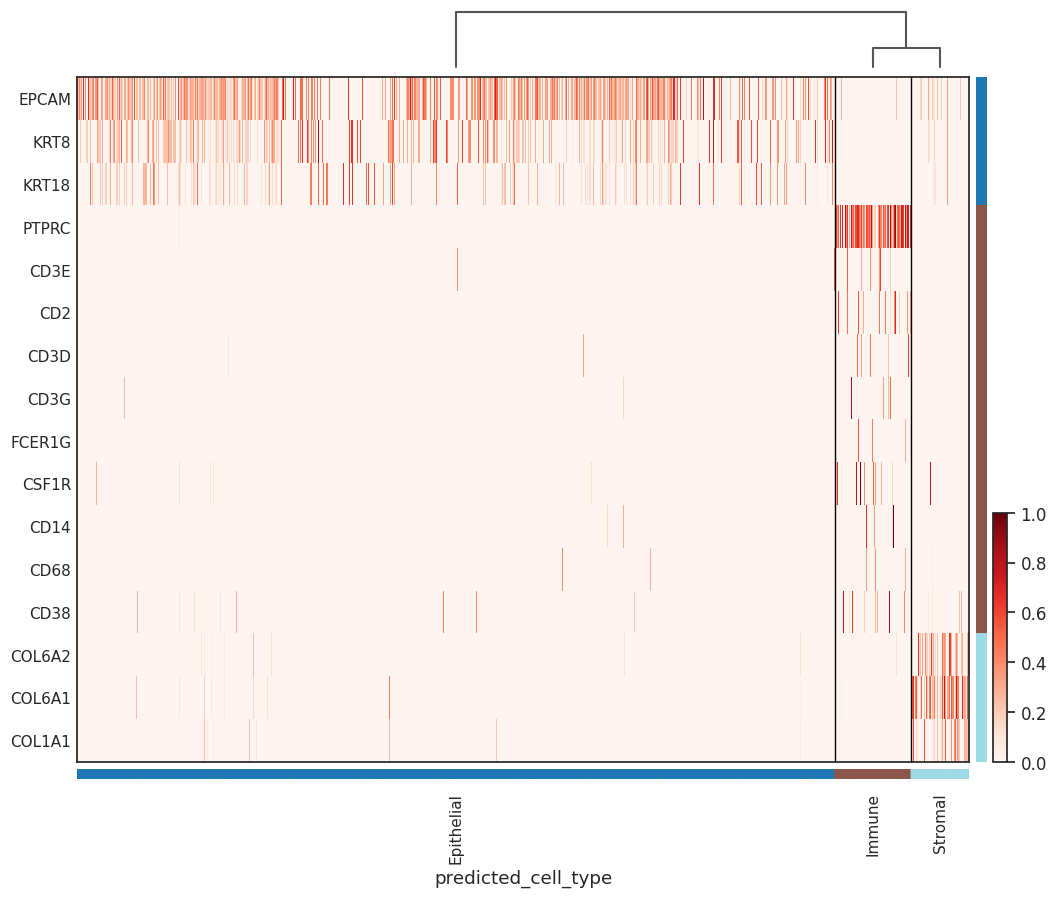

In [16]:
import os

# Create and store the heatmap object
normal_colon_hm = sc.pl.heatmap(
    combined_by_tissue["Normal Colon"],
    var_names=colon_marker_dict,
    groupby="predicted_cell_type",
    use_raw=False,
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_rotation=90,
    var_group_labels=colon_marker_dict.keys(),
    dendrogram=True,
    figsize=(12, 10),
    show=False,  # Prevent auto display
)


# Set title and adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_marker_gene_heatmap.png"))

#### Plot Marker Gene Expression UMAPs

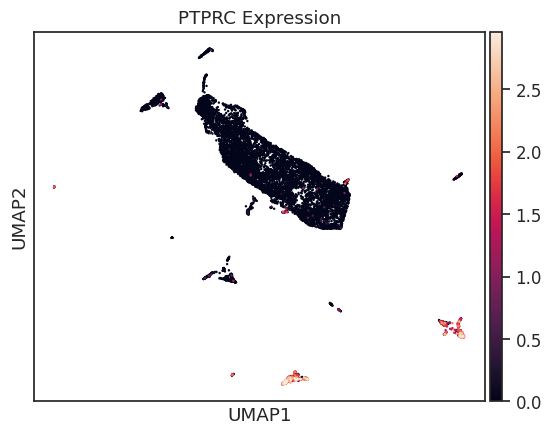

In [17]:
# Immune Marker (PTPRC)
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="PTPRC",
    title="PTPRC Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

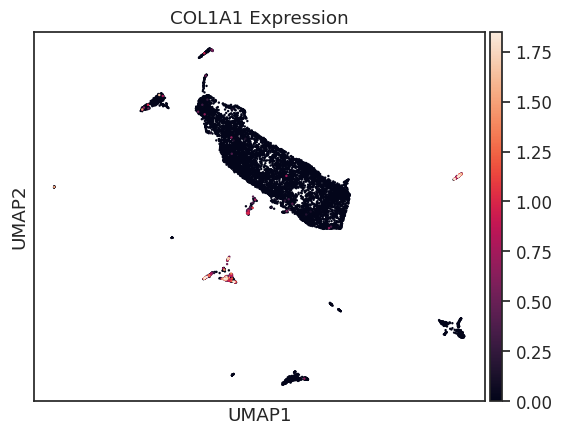

In [18]:
# Stromal Marker (COL6A1)
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="COL1A1",
    title="COL1A1 Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

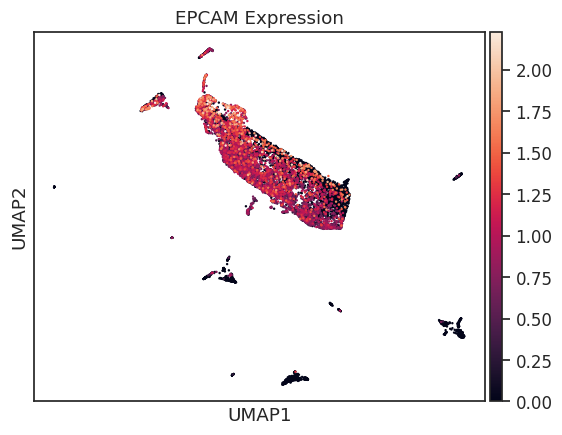

In [19]:
# Epithelial Marker (EPCAM)
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="EPCAM",
    title="EPCAM Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

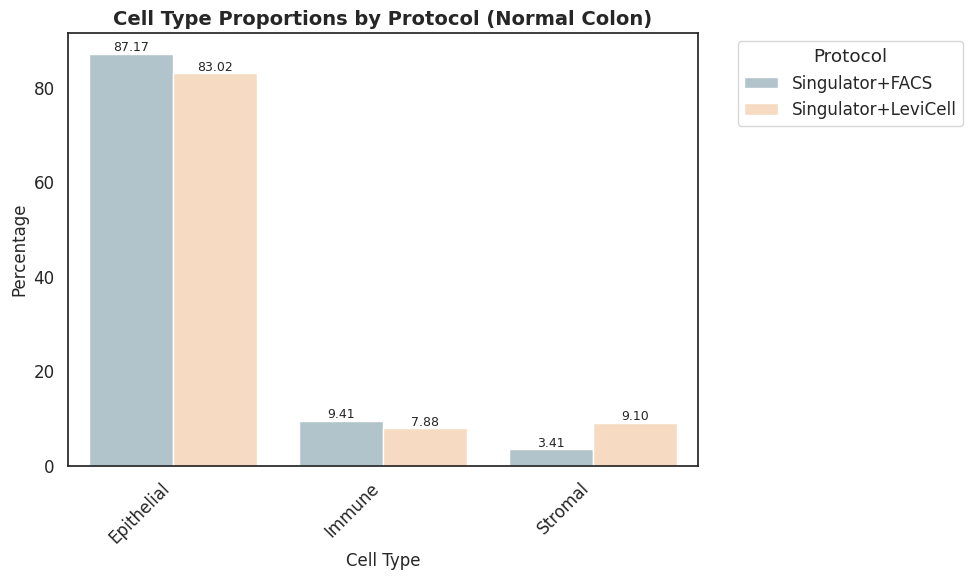

In [20]:
# Plot cell type proportions by protocol for Normal Liver
fig = plot_celltype_proportions_by_protocol(
    adata=combined_by_tissue["Normal Colon"],
    tissue="Normal Colon",
    metric="predicted_cell_type",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_cell_type_proportions.png"), bbox_inches="tight")

## Tumor Colon

genes are not in var_names and ignored: Index(['CD3E', 'CD3D', 'CD3G', 'FCER1G', 'CD14', 'CD68'], dtype='object')
... storing 'predicted_cell_type' as categorical


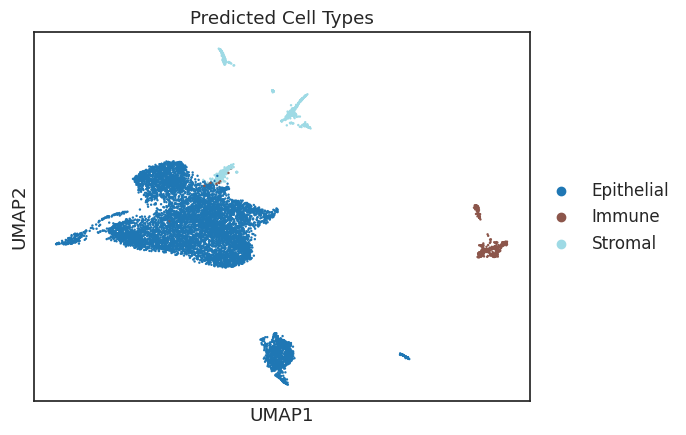

In [21]:
# Assign cell types to the colon adata
assign_celltypes_by_marker_scoring(
    adata=combined_by_tissue["Tumor Colon"],
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
    use_raw=False,
    min_counts=None,
    min_score=0.15,
)

# Plot UMAP with predicted cell types for Normal Colon
sc.pl.umap(
    combined_by_tissue["Tumor Colon"],
    color="predicted_cell_type",
    title="Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

dendrogram data not found (using key=dendrogram_predicted_cell_type). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


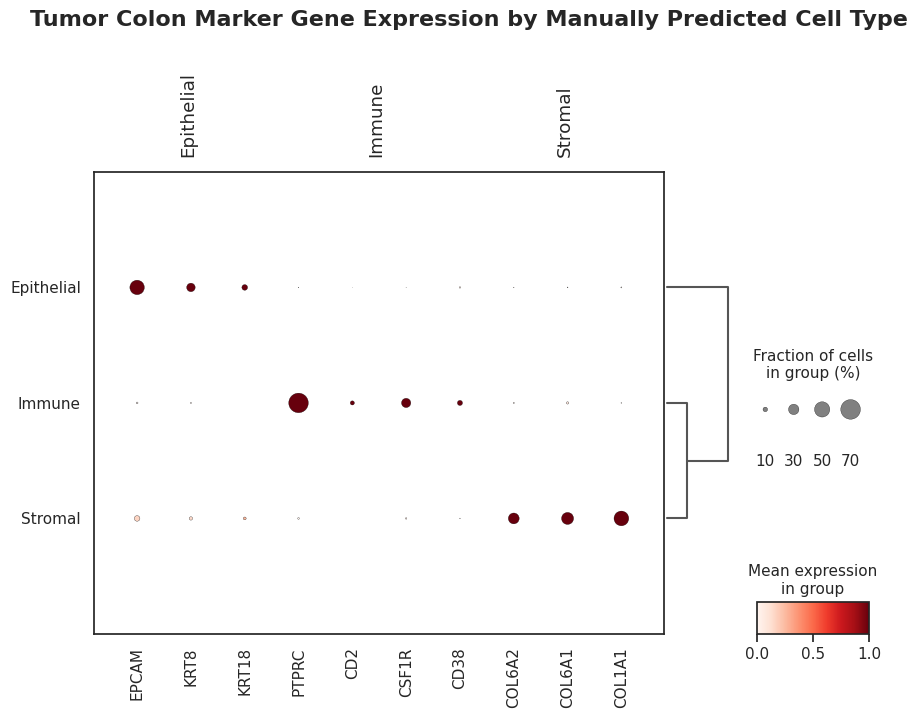

In [22]:
# Filter genes in colon_marker_dict to only those present in combined_by_tissue["Tumor Colon"].var_names
filtered_tumor_colon_dict = {
    group: [gene for gene in genes if gene in combined_by_tissue["Tumor Colon"].var_names]
    for group, genes in colon_marker_dict.items()
}


# Create the dotplot
tumor_colon_dp = sc.pl.dotplot(
    combined_by_tissue["Tumor Colon"],
    var_names=filtered_tumor_colon_dict,
    groupby="predicted_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = tumor_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Tumor Colon Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_marker_dot_plot.png"))

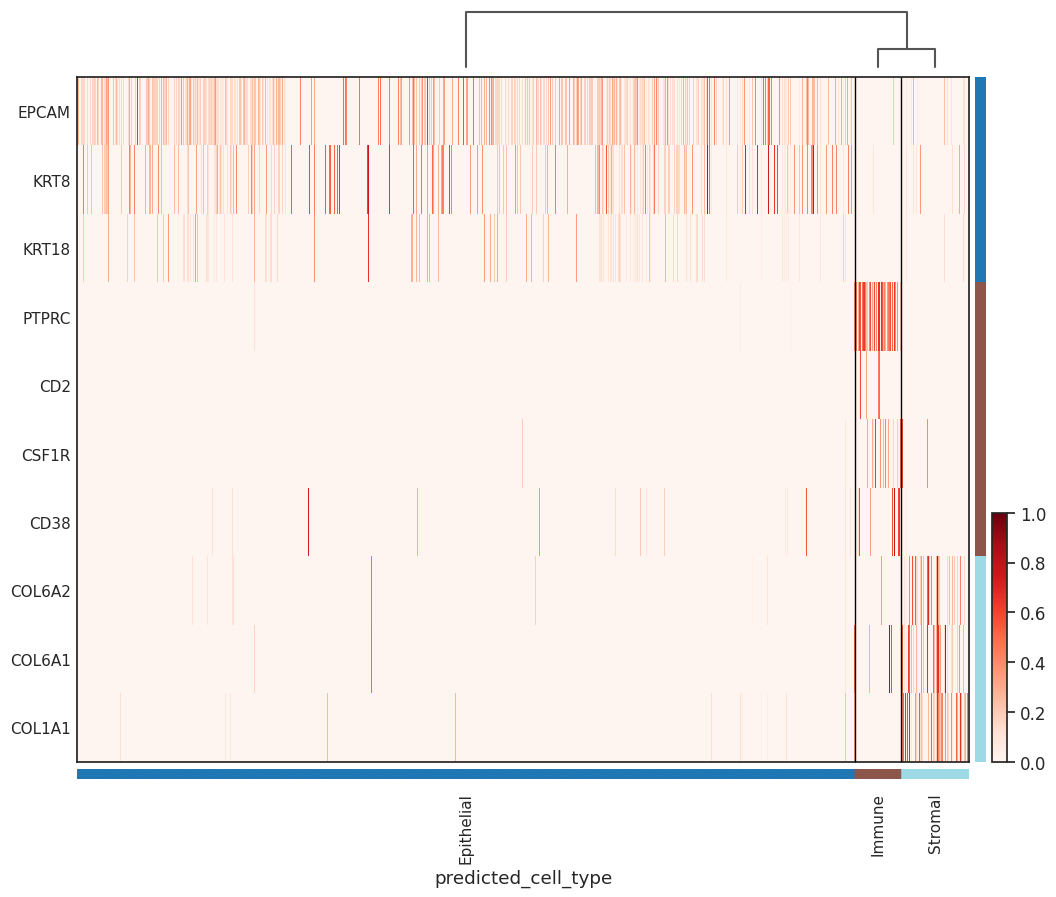

In [23]:
import os

# Create and store the heatmap object
normal_colon_hm = sc.pl.heatmap(
    combined_by_tissue["Tumor Colon"],
    var_names=filtered_tumor_colon_dict,
    groupby="predicted_cell_type",
    use_raw=False,
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_rotation=90,
    var_group_labels=filtered_tumor_colon_dict.keys(),
    dendrogram=True,
    figsize=(12, 10),
    show=False,  # Prevent auto display
)


# Set title and adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_marker_gene_heatmap.png"))

#### Plot Marker Gene Expression UMAPs

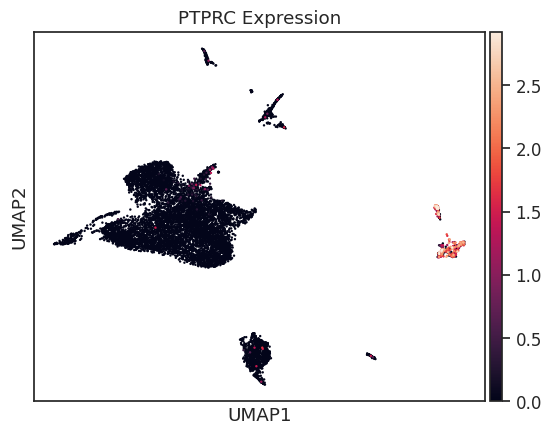

In [24]:
# Immune Marker (PTPRC)
sc.pl.umap(
    combined_by_tissue["Tumor Colon"],
    color="PTPRC",
    title="PTPRC Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

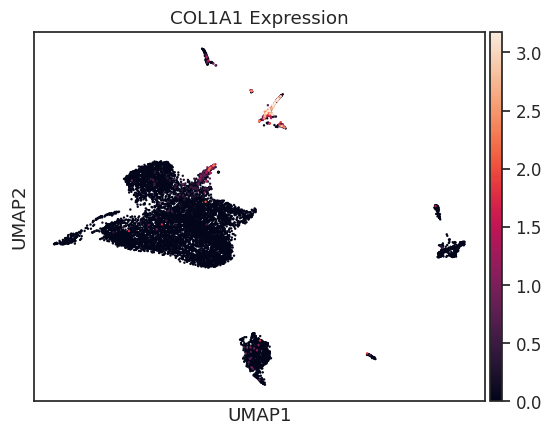

In [25]:
# Stromal Marker (COL6A1)
sc.pl.umap(
    combined_by_tissue["Tumor Colon"],
    color="COL1A1",
    title="COL1A1 Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

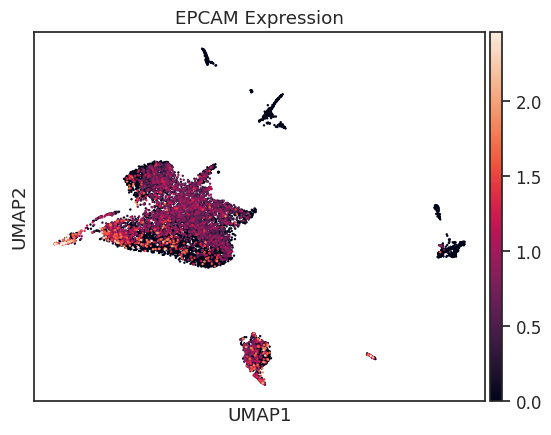

In [26]:
# Epithelial Marker (EPCAM)
sc.pl.umap(
    combined_by_tissue["Tumor Colon"],
    color="EPCAM",
    title="EPCAM Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

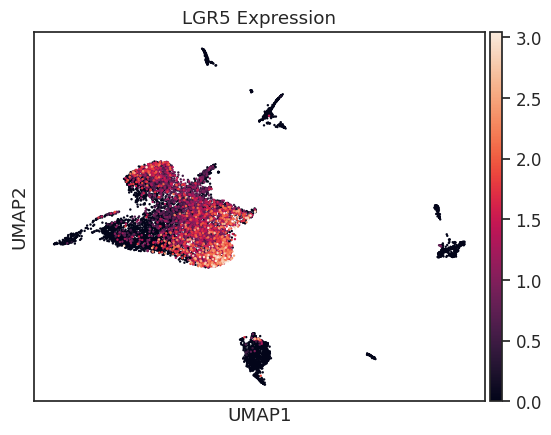

In [27]:
# Cancer/Stem cell Marker (LGR5)
sc.pl.umap(
    combined_by_tissue["Tumor Colon"],
    color="LGR5",
    title="LGR5 Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

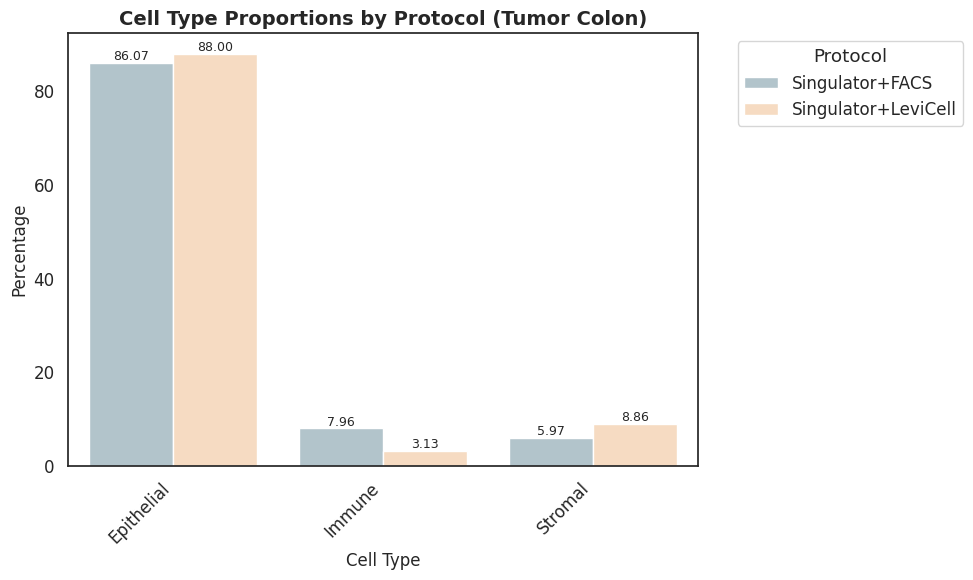

In [28]:
# Plot cell type proportions by protocol for Tumor Colon
fig = plot_celltype_proportions_by_protocol(
    adata=combined_by_tissue["Tumor Colon"],
    tissue="Tumor Colon",
    metric="predicted_cell_type",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_cell_type_proportions.png"), bbox_inches="tight")

In [29]:
complete_colon_adata = sc.concat(
    [combined_by_tissue["Normal Colon"], combined_by_tissue["Tumor Colon"]],
)

epithelial_colon_adata = complete_colon_adata[
    complete_colon_adata.obs["predicted_cell_type"] == "Epithelial"
].copy()

epithelial_colon_adata.obs_names_make_unique()
epithelial_colon_adata.var_names_make_unique()

# Compute graphs
sc.pp.highly_variable_genes(
    epithelial_colon_adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    batch_key="tissue",
    layer="raw_data",
)  # Using batch_key to account for protocol differences - want to keep genes that are variable across both protocols
sc.pp.pca(
    epithelial_colon_adata, n_comps=None, use_highly_variable=True, random_state=0
)  #  Roshan's workshop calculated 100 comps, then moved forward with 30, but this took long - if set to None, "Defaults to 50, or (1 - minimum dimension size of selected representation)"
sc.pp.neighbors(
    epithelial_colon_adata, n_neighbors=30, use_rep="X_pca", metric="euclidean", random_state=0
)  # From Roshan's workshop

# Compute UMAP and clustering
sc.tl.umap(epithelial_colon_adata, min_dist=0.1, random_state=0)  # From Roshan's workshop
sc.tl.leiden(epithelial_colon_adata, resolution=1, random_state=0)  # From Roshan's workshop

In [30]:
epithelial_colon_adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,total_counts_mitochondrial,pct_counts_mitochondrial,total_counts_ribosomal,pct_counts_ribosomal,total_counts_apoptosis,...,predicted_doublet,protocol,tissue,sample,n_genes,leiden,Epithelial_score,Stromal_score,Immune_score,predicted_cell_type
CGCCAGACAGCTAACT-1,7456,8.916908,34668,10.453601,34668,5,0.014423,103,0.297104,310,...,False,Singulator+FACS,Normal Colon,SF_N,7456,8,-0.179613,-0.050021,-0.024887,Epithelial
CATGCCTGTAAGTAGT-1,6634,8.800114,31454,10.356313,31454,0,0.000000,71,0.225726,305,...,False,Singulator+FACS,Normal Colon,SF_N,6634,11,0.183833,-0.033033,-0.022806,Epithelial
TCACTATTCAATCTTC-1,6426,8.768263,27739,10.230631,27739,0,0.000000,128,0.461444,226,...,False,Singulator+FACS,Normal Colon,SF_N,6426,1,-0.130342,-0.018929,-0.027205,Epithelial
TTCCGGTCAATTTCCT-1,6223,8.736168,26108,10.170035,26108,0,0.000000,59,0.225984,212,...,False,Singulator+FACS,Normal Colon,SF_N,6223,6,-0.081701,-0.029910,-0.022247,Epithelial
TCCTCCCTCTCTTAAC-1,5910,8.684570,25824,10.159098,25824,0,0.000000,90,0.348513,177,...,False,Singulator+FACS,Normal Colon,SF_N,5910,5,-0.079753,-0.018955,-0.022479,Epithelial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACCGGGCACTCCCTA-1,617,6.426488,703,6.556778,703,0,0.000000,1,0.142248,8,...,False,Singulator+LeviCell,Tumor Colon,SL_T,617,4,0.492489,-0.044071,-0.043777,Epithelial
CCGTGAGGTTGCTTGA-1,232,5.451038,513,6.242223,513,2,0.389864,80,15.594542,2,...,False,Singulator+LeviCell,Tumor Colon,SL_T,232,14,-0.054850,-0.070528,-0.019312,Epithelial
TCCTCCCGTATAGCTC-1,195,5.278115,635,6.455199,635,0,0.000000,16,2.519685,6,...,False,Singulator+LeviCell,Tumor Colon,SL_T,195,14,-0.034489,-0.061893,-0.049984,Epithelial
ATCCCTGAGAACTGAT-1,482,6.180017,531,6.276643,531,0,0.000000,0,0.000000,5,...,False,Singulator+LeviCell,Tumor Colon,SL_T,482,4,-0.091527,-0.012575,0.000000,Epithelial


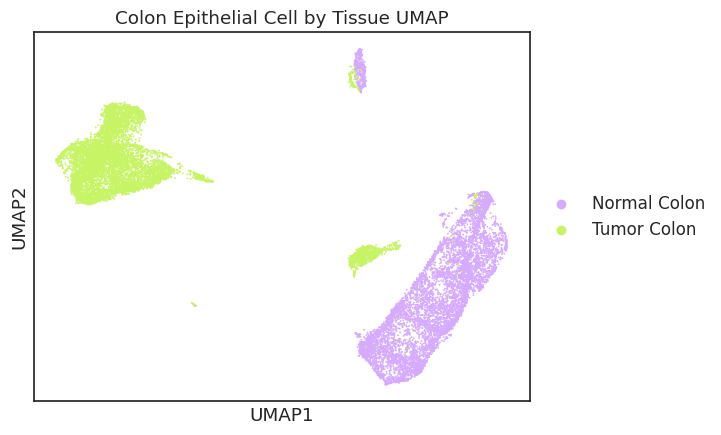

In [49]:
colon_tissue_color_palette = {
    "Normal Colon": "#D5AAFF",  # pastel purple
    "Tumor Colon": "#C7F464",   # pastel lime green
}

sc.pl.umap(
    epithelial_colon_adata,
    color="tissue",
    title="Colon Epithelial Cell by Tissue UMAP",
    legend_loc="right margin",
    palette=colon_tissue_color_palette,
    frameon=True,
)

In [33]:
import pandas as pd
import gzip

def parse_gtf_with_combined_lookup(gtf_path):
    """Parse GTF and return DataFrame with combined gene_id and gene_name indexing."""
    records = []
    with gzip.open(gtf_path, "rt") if gtf_path.endswith(".gz") else open(gtf_path) as f:
        for line in f:
            if line.startswith("#"): continue
            fields = line.strip().split("\t")
            if fields[2] != "gene": continue

            chrom, start, end, attributes = fields[0], int(fields[3]), int(fields[4]), fields[8]
            attr_dict = {
                k.strip(): v.strip('"')
                for attr in attributes.strip().split(";") if attr.strip()
                for k, v in [attr.strip().split(" ", 1)]
            }

            gene_id = attr_dict.get("gene_id")
            gene_name = attr_dict.get("gene_name")
            if gene_id and gene_name:
                records.append((gene_id, gene_name, chrom, start, end))

    df = pd.DataFrame(records, columns=["gene_id", "gene_name", "chromosome", "start", "end"])

    # Two dataframes for matching
    by_id = df.drop_duplicates("gene_id").set_index("gene_id")
    by_name = df.drop_duplicates("gene_name").set_index("gene_name")

    # Merge on outer keys (index), prefer Ensembl ID matches but fill from gene symbol if missing
    combined = by_id.combine_first(by_name)

    return combined


In [35]:
gene_coords = parse_gtf_with_combined_lookup(os.path.join(GENE_SETS_DIR, "Homo_sapiens.GRCh38.114.gtf.gz"))

matched = gene_coords.reindex(complete_colon_adata.var_names)

epithelial_colon_adata.var["chromosome"] = "chr" + matched["chromosome"].fillna("NA").astype(str)
epithelial_colon_adata.var["start"] = matched["start"].astype("Int64")
epithelial_colon_adata.var["end"] = matched["end"].astype("Int64")

# Define valid chromosomes: chr1 to chr23 (autosomes + chr23)
valid_chroms = {f"chr{i}" for i in range(1, 24)}

# Create mask for genes on valid chromosomes
valid_mask = epithelial_colon_adata.var["chromosome"].isin(valid_chroms)

# Subset AnnData
epithelial_colon_adata = epithelial_colon_adata[:, valid_mask].copy()

In [36]:
import infercnvpy as cnv

cnv.tl.infercnv(
    epithelial_colon_adata,
    reference_key="tissue",
    reference_cat = "Normal Colon", 
    )

  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
cnv.pp.neighbors(epithelial_colon_adata, n_neighbors=30, n_pcs=50, random_state=42)

cnv.tl.leiden(epithelial_colon_adata)
epithelial_colon_adata.obs

X_cnv_pca not found in adata.obsm. Computing PCA with default parameters


,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,total_counts_mitochondrial,pct_counts_mitochondrial,total_counts_ribosomal,pct_counts_ribosomal,total_counts_apoptosis,...,protocol,tissue,sample,n_genes,leiden,Epithelial_score,Stromal_score,Immune_score,predicted_cell_type,cnv_leiden
CGCCAGACAGCTAACT-1,7456,8.916908,34668,10.453601,34668,5,0.014423,103,0.297104,310,...,Singulator+FACS,Normal Colon,SF_N,7456,8,-0.179613,-0.050021,-0.024887,Epithelial,6
CATGCCTGTAAGTAGT-1,6634,8.800114,31454,10.356313,31454,0,0.000000,71,0.225726,305,...,Singulator+FACS,Normal Colon,SF_N,6634,11,0.183833,-0.033033,-0.022806,Epithelial,7
TCACTATTCAATCTTC-1,6426,8.768263,27739,10.230631,27739,0,0.000000,128,0.461444,226,...,Singulator+FACS,Normal Colon,SF_N,6426,1,-0.130342,-0.018929,-0.027205,Epithelial,0
TTCCGGTCAATTTCCT-1,6223,8.736168,26108,10.170035,26108,0,0.000000,59,0.225984,212,...,Singulator+FACS,Normal Colon,SF_N,6223,6,-0.081701,-0.029910,-0.022247,Epithelial,1
TCCTCCCTCTCTTAAC-1,5910,8.684570,25824,10.159098,25824,0,0.000000,90,0.348513,177,...,Singulator+FACS,Normal Colon,SF_N,5910,5,-0.079753,-0.018955,-0.022479,Epithelial,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACCGGGCACTCCCTA-1,617,6.426488,703,6.556778,703,0,0.000000,1,0.142248,8,...,Singulator+LeviCell,Tumor Colon,SL_T,617,4,0.492489,-0.044071,-0.043777,Epithelial,4
CCGTGAGGTTGCTTGA-1,232,5.451038,513,6.242223,513,2,0.389864,80,15.594542,2,...,Singulator+LeviCell,Tumor Colon,SL_T,232,14,-0.054850,-0.070528,-0.019312,Epithelial,8
TCCTCCCGTATAGCTC-1,195,5.278115,635,6.455199,635,0,0.000000,16,2.519685,6,...,Singulator+LeviCell,Tumor Colon,SL_T,195,14,-0.034489,-0.061893,-0.049984,Epithelial,8
ATCCCTGAGAACTGAT-1,482,6.180017,531,6.276643,531,0,0.000000,0,0.000000,5,...,Singulator+LeviCell,Tumor Colon,SL_T,482,4,-0.091527,-0.012575,0.000000,Epithelial,4


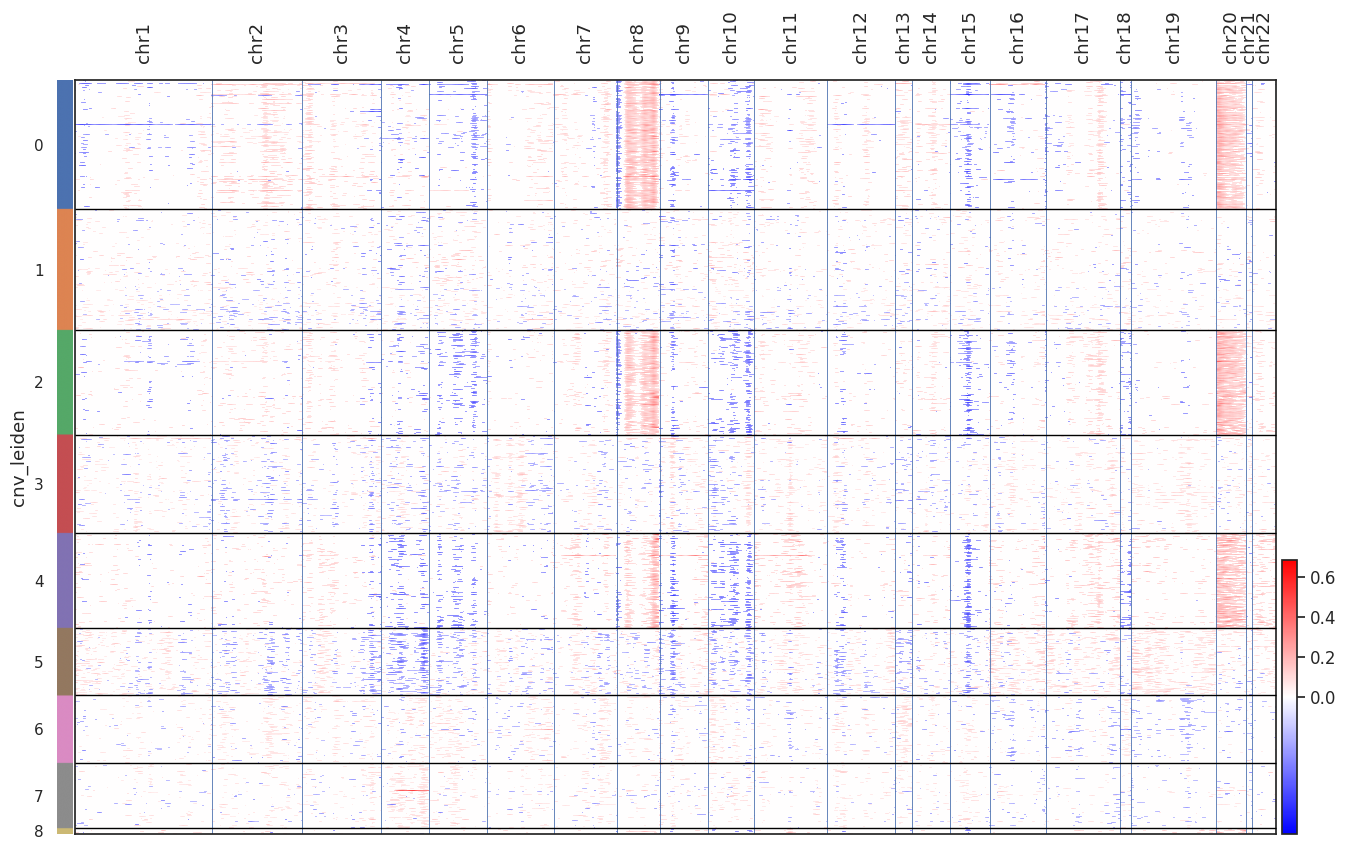

In [38]:
cnv.pl.chromosome_heatmap(epithelial_colon_adata, groupby="cnv_leiden")

... storing 'chromosome' as categorical


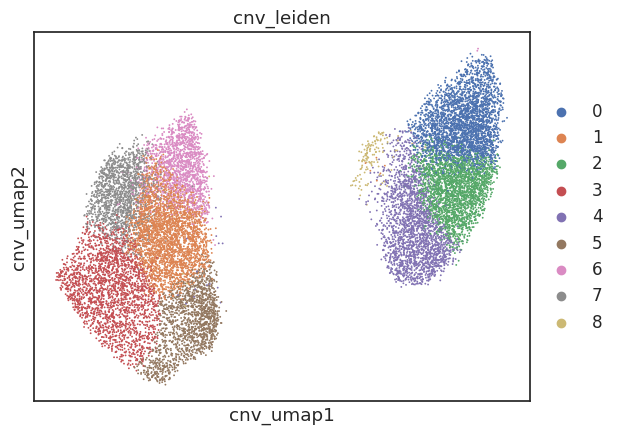

In [39]:
cnv.tl.umap(epithelial_colon_adata)
cnv.pl.umap(epithelial_colon_adata, color=["cnv_leiden"], wspace=0.4)

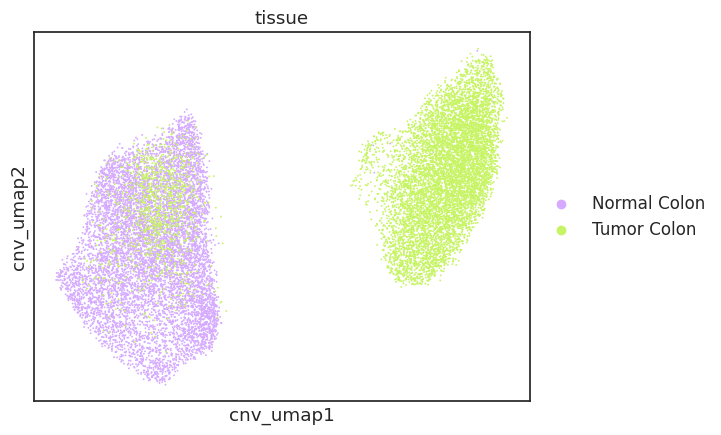

In [51]:
# cnv.tl.umap(complete_colon_adata)
cnv.pl.umap(epithelial_colon_adata, color=["tissue"], palette = colon_tissue_color_palette, wspace=0.4)

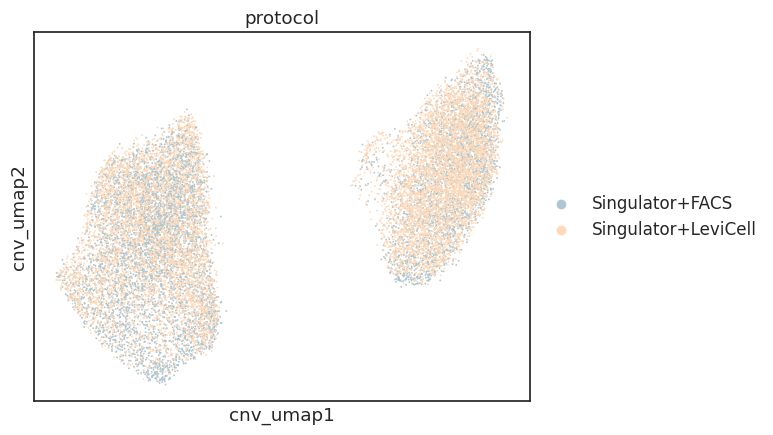

In [50]:
# cnv.tl.umap(complete_colon_adata)
cnv.pl.umap(epithelial_colon_adata, color=["protocol"], palette = protocol_color_palette, wspace=0.4)

In [52]:
# Create a new column 'tumor_classification' based on conditions
def classify_tumor_cells(row):
    if row["tissue"] == "Tumor Colon":
        if row["cnv_leiden"] in ["0", "2", "4", "8"]:  # ensure string match
            return "Tumor_Tumor Colon"
        else:
            return "Normal_Tumor Colon"
    else:
        return None

epithelial_colon_adata.obs["tumor_classification"] = epithelial_colon_adata.obs.apply(classify_tumor_cells, axis=1)


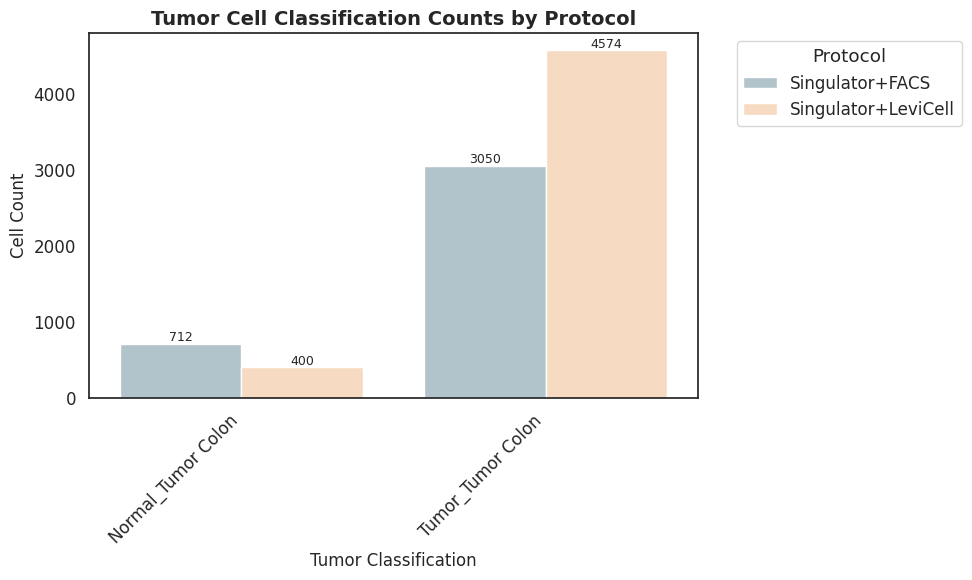

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter cells with tumor classification
tumor_classified = epithelial_colon_adata.obs[epithelial_colon_adata.obs["tumor_classification"].notnull()].copy()

# Count cells per protocol and tumor classification
counts = (
    tumor_classified
    .groupby(["protocol", "tumor_classification"])
    .size()
    .reset_index(name="count")
)

# Plotting
sns.set_theme(style="white", font_scale=1.1)
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=counts,
    x="tumor_classification",
    y="count",
    hue="protocol",
    palette=protocol_color_palette,
    ax=ax,
    dodge=True,
)

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{int(height)}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
            fontsize=9,
        )

# Format plot
ax.set_title("Tumor Cell Classification Counts by Protocol", fontsize=14, weight="bold")
ax.set_xlabel("Tumor Classification", fontsize=12)
ax.set_ylabel("Cell Count", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="Protocol", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()